In [1]:
import os
import sys

project_dir = os.path.realpath(os.path.join(os.getcwd(), '..','..','..','..'))
data_dir = os.path.join(project_dir, 'ORATS','parquet')
tickerdata_dir = os.path.join(project_dir, 'ORATS','byticker')
data_clean_dir = os.path.join(project_dir, 'repository','utils')

sys.path.append(data_clean_dir)

In [25]:
import imp
import anomaly_detection_class
imp.reload(anomaly_detection_class)
from anomaly_detection_class import anomalyDetector

In [2]:
from orats_cleaner import *
from workers import get_all_price
from anomaly_detection_class import anomalyDetector
from anomaly_detection_helper import train_test_split
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [3]:
filelist = generate_file_list(data_dir, '201901','202105')

In [4]:
tickers = ['BIGC','BMY','CRTO','KSS','MSFT','PTON','PYPL','SPWR','TD','TSEM','WKHS']

In [5]:
optiondata = read_optiondata_by_ticker(filelist, tickers)
filename = 'VIXsymbol_data2.parquet'
optiondata.to_parquet(filename)

D:\jupyter\wooji\ORATS\parquet\2019\ORATS_SMV_Stries_201901.parquet done!
D:\jupyter\wooji\ORATS\parquet\2019\ORATS_SMV_Stries_201902.parquet done!
D:\jupyter\wooji\ORATS\parquet\2019\ORATS_SMV_Stries_201903.parquet done!
D:\jupyter\wooji\ORATS\parquet\2019\ORATS_SMV_Stries_201904.parquet done!
D:\jupyter\wooji\ORATS\parquet\2019\ORATS_SMV_Stries_201905.parquet done!
D:\jupyter\wooji\ORATS\parquet\2019\ORATS_SMV_Stries_201906.parquet done!
D:\jupyter\wooji\ORATS\parquet\2019\ORATS_SMV_Stries_201907.parquet done!
D:\jupyter\wooji\ORATS\parquet\2019\ORATS_SMV_Stries_201908.parquet done!
D:\jupyter\wooji\ORATS\parquet\2019\ORATS_SMV_Stries_201909.parquet done!
D:\jupyter\wooji\ORATS\parquet\2019\ORATS_SMV_Stries_201910.parquet done!
D:\jupyter\wooji\ORATS\parquet\2019\ORATS_SMV_Stries_201911.parquet done!
D:\jupyter\wooji\ORATS\parquet\2019\ORATS_SMV_Stries_201912.parquet done!
D:\jupyter\wooji\ORATS\parquet\2020\ORATS_SMV_Stries_202001.parquet done!
D:\jupyter\wooji\ORATS\parquet\2020\OR

In [6]:
A2 = {'variable':['volume','pcratio','impliedvol'], 
        'direction':['>','<','>'], 
        'volume_operation':'sum', 
        'window':60, 
        'log_trans':False}

thresh = [1.3, 1.2, 0.5]

split_date = '2019-06-01'
window = 60
win_thresh = 0

In [27]:
ad_dic = {}
outlier_dates = {}
next5thday_ret_dic = {}
for t in tickers:
    _, test = train_test_split(optiondata[optiondata['underlying']==t], split_date, window=window)
    ad = anomalyDetector()
    ad.compile(_type='call', expiry='next', monthly=True, moneyness='otm', params=A2)
    
    next5thday_ret_dic[t] = ad.predict(test, win_thresh, thresh, verbose=True)
    ad_dic[t] = ad
    outlier_dates[t] = ad._test_outlier

+1 day stock price increase probability: 0.75
+1 day stock price avg increase: 0.048
+1 day stock price avg decrease -0.098 

+5 day stock price increase probability: 0.75
+5 day stock price avg increase: 0.058
+5 day stock price avg decrease: -0.018
+5 day expected return: 0.03900000000000001 

+1 day stock price increase probability: 0.684
+1 day stock price avg increase: 0.015
+1 day stock price avg decrease -0.019 

+5 day stock price increase probability: 0.789
+5 day stock price avg increase: 0.041
+5 day stock price avg decrease: -0.027
+5 day expected return: 0.026652000000000002 

+1 day stock price increase probability: 0.692
+1 day stock price avg increase: 0.047
+1 day stock price avg decrease -0.054 

+5 day stock price increase probability: 0.769
+5 day stock price avg increase: 0.118
+5 day stock price avg decrease: -0.072
+5 day expected return: 0.07411000000000001 

+1 day stock price increase probability: 0.455
+1 day stock price avg increase: 0.072
+1 day stock price

In [9]:
start = '2019-01-01'
end = '2021-06-20'
vix = get_all_price(['^VIX'],start,end)

[*********************100%***********************]  1 of 1 completed


In [29]:
next5thday_ret_dic['KSS']

,outlierday,nextday,5thday,5thday_return
quotedate,,,,
2019-12-09,48.64,47.98,49.60,0.019545
2020-03-13,23.90,19.82,15.73,-0.418309
2020-03-23,12.90,16.41,15.85,0.205942
2020-03-31,14.56,12.86,17.14,0.163137
2020-04-20,17.10,16.44,18.54,0.080852
2020-05-13,16.14,16.56,16.85,0.043050
2020-05-20,16.85,18.05,20.20,0.181332
2020-09-29,18.45,18.48,19.53,0.056887
2020-10-01,19.38,19.88,21.70,0.113071


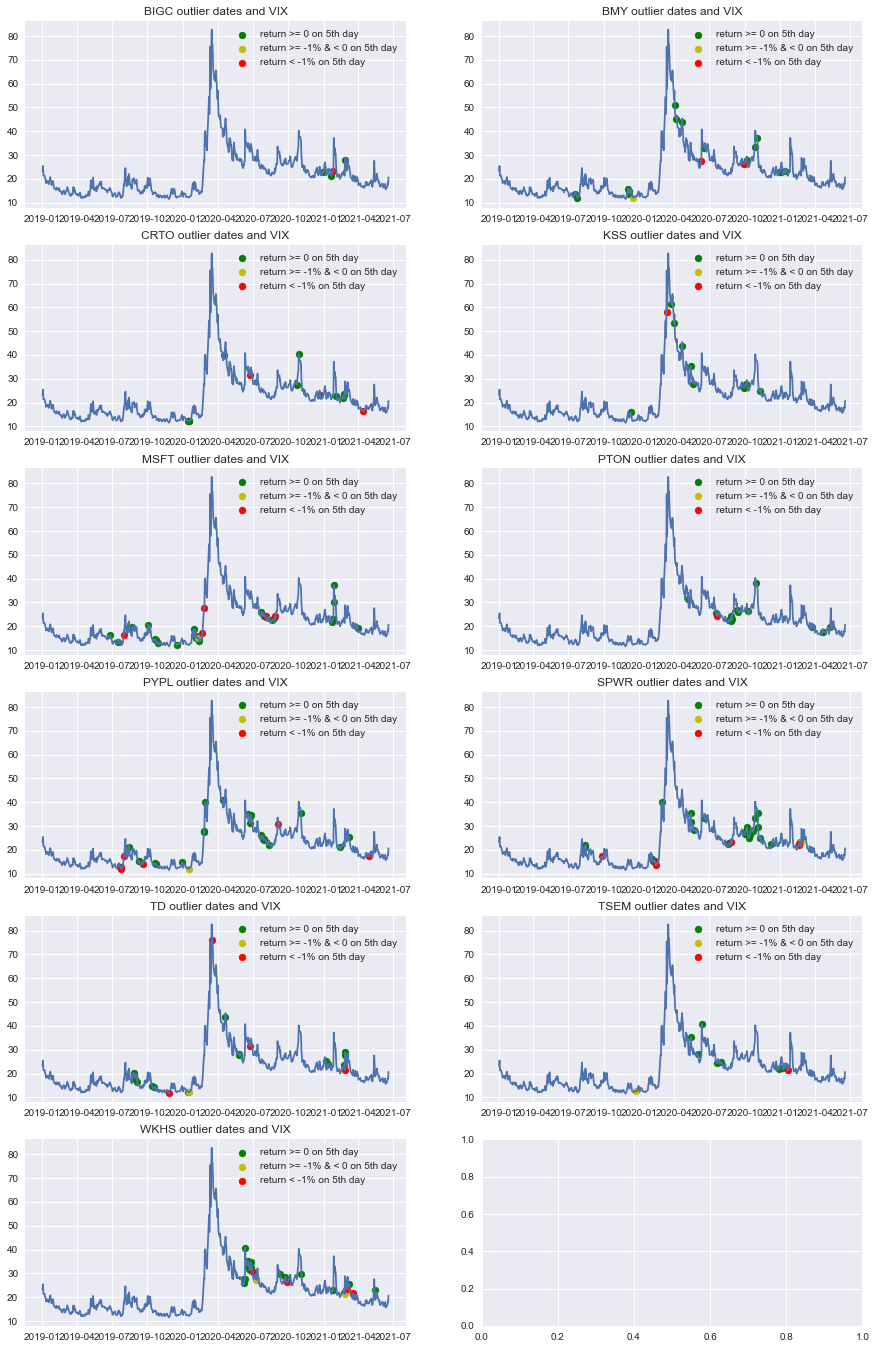

In [28]:
fig, axes = plt.subplots(6,2, figsize=(15, 24))
axes = axes.ravel()
for i, t in enumerate(tickers):
    next5thday_ret = next5thday_ret_dic[t]['5thday_return']
    ret_pos_date = next5thday_ret[next5thday_ret>=0].index
    ret_neg1_date = next5thday_ret[(next5thday_ret>=-0.01) & (next5thday_ret<0)].index
    ret_neg2_date = next5thday_ret[next5thday_ret<-0.01].index
    
    axes[i].plot(vix['close'])
    axes[i].scatter(ret_pos_date, vix['close'].loc[ret_pos_date], c='g', label='return >= 0 on 5th day')
    axes[i].scatter(ret_neg1_date, vix['close'].loc[ret_neg1_date], c='y', label='return >= -1% & < 0 on 5th day')
    axes[i].scatter(ret_neg2_date, vix['close'].loc[ret_neg2_date], c='r', label='return < -1% on 5th day')
    axes[i].legend()
    axes[i].set_title(t+' outlier dates and VIX')